In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import gensim
import nltk
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

from decouple import config
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
from gsdmm import MovieGroupProcess
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")

/Users/danipinho/Documents/dev/Projects/ons_twitter/.ons_twitter/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danipinho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/danipinho/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
DATA_PATH = config("DATA_PATH")

In [3]:
data = pd.read_json(DATA_PATH + "/Data/tweets_preprocessed_json.json")

In [4]:
data.head()

query  \
0  Operador Nacional do Sistema Eletrico   
1  Operador Nacional do Sistema Eletrico   
2  Operador Nacional do Sistema Eletrico   
3  Operador Nacional do Sistema Eletrico   
4  Operador Nacional do Sistema Eletrico   

                                                text  \
0  O ONS - Operador Nacional do Sistema Elétrico ...   
1  O Nordeste registrou no domingo um recorde de ...   
2  É melhor o Operador Nacional do Sistema Elétri...   
3  Visita Técnica ao Operador Nacional do Sistema...   
4  New post in Forex Consultor Expert BR News: Mo...   

                                          clean_text  \
0  ons chesf iniciaram imediatamente retomada car...   
1  nordeste registrou domingo recorde geracao ene...   
2  melhor aumentar producao hoje tende ficar inst...   
3                    visita tecnica ons brasilia ons   
4  new post forex consultor expert news money tim...   

                                          text_token  
0  [ons, chesf, iniciaram, imediatamente, retomad...  
1  [nordeste, registrou, domingo, recorde, geraca...  
2  [melhor, aumentar, producao, hoje, tende, fica...  
3              [visita, tecnica, ons, brasilia, ons]  
4  [new, post, forex, consultor, expert, news, mo...

## Code

### LDA (gensim)

In [5]:
docs = data["text_token"].to_numpy() 

In [6]:
docs

array([list(['ons', 'chesf', 'iniciaram', 'imediatamente', 'retomada', 'cargas', 'concessionaria', 'servico', 'normalizado', 'gradativamente', 'pouco', 'tempo', 'todos', 'clientes', 'fornecimento', 'regularizado']),
       list(['nordeste', 'registrou', 'domingo', 'recorde', 'geracao', 'energia', 'solar', 'fotovoltaica', 'instantanea', 'gigawatts', 'gerados', '10h45', 'informou', 'nesta', 'segunda', 'feira', 'ons']),
       list(['melhor', 'aumentar', 'producao', 'hoje', 'tende', 'ficar', 'instavel', 'tanto', 'secador', 'ligado']),
       ...,
       list(['parcelado', 'secador', 'cabelos', 'britania', 'sp3300v', 'emissao', 'ions']),
       list(['nordeste', 'fez', 'ligeiro', 'ajuste', 'cima', 'estimativa', 'chuvas', 'media', 'historica', 'operador', 'estimou', 'reservatorios', 'hidreletricas', 'sudeste', 'centro', 'oeste', 'devem', 'alcancar', 'capacidade', 'final', 'junho']),
       list(['fsp', 'diz', 'operador', 'nacional', 'sistema', 'passou', 'esperar', 'queda', 'carga', 'naciona

In [7]:
dictionary = Dictionary(docs)

In [8]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [9]:
bow_corpus = [dictionary.doc2bow(doc) for doc in docs]

In [10]:
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                         num_topics=50, 
                                         id2word=dictionary, 
                                         passes=4, 
                                         workers=2,
                                         random_state=42)

In [11]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.094*"governo" + 0.069*"crise" + 0.063*"acoes" + 0.054*"atencao" + 0.047*"ainda" + 0.047*"hidrica" + 0.026*"ponto" + 0.024*"2022" + 0.018*"desse" + 0.018*"350"
Topic: 1 
Words: 0.086*"energia" + 0.028*"agua" + 0.022*"esgoto" + 0.021*"minas" + 0.021*"iluminacao" + 0.021*"ministerio" + 0.020*"completa" + 0.019*"publica" + 0.019*"reino" + 0.018*"alem"
Topic: 2 
Words: 0.053*"sim" + 0.047*"obtidos" + 0.040*"jogo" + 0.037*"contra" + 0.029*"fazer" + 0.024*"acho" + 0.019*"serio" + 0.018*"fala" + 0.018*"todos" + 0.017*"bom"
Topic: 3 
Words: 0.051*"assim" + 0.032*"tanto" + 0.028*"nunca" + 0.025*"cara" + 0.019*"tempo" + 0.017*"voltar" + 0.017*"caro" + 0.016*"simples" + 0.015*"real" + 0.015*"ainda"
Topic: 4 
Words: 0.043*"bandeira" + 0.037*"amarela" + 0.036*"vermelha" + 0.034*"chuva" + 0.025*"fios" + 0.023*"retorno" + 0.022*"conta" + 0.017*"lendo" + 0.017*"forte" + 0.015*"luz"
Topic: 5 
Words: 0.064*"ver" + 0.059*"bravo" + 0.037*"sempre" + 0.021*"hora" + 0.020*"petroleo" + 0.020

### LDA (sklearn)

In [12]:
tfidf = TfidfVectorizer(lowercase=True,
                        min_df=10,
                        max_features=5000)
tfidf.fit(data["clean_text"])
data.loc[:, "tfidf"] = data["clean_text"].apply(lambda t: tfidf.transform([t]).toarray()[0])


In [13]:
corpus_lda = np.array(data.tfidf.tolist())

In [14]:
def get_model_topics(model, vectorizer, n_top_words=10):
    word_dict = {}
    feature_names = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        word_dict[topic_idx] = top_features

    return pd.DataFrame(word_dict)

In [15]:
lda_skl = LDA(n_components=50, random_state=42).fit(corpus_lda)

In [16]:
get_model_topics(lda_skl, tfidf)

0             1           2         3             4   \
0           tbm  praticamente     litoral       ons          data   
1       privada       energia         sul   diretor          base   
2         porto       geracao         via     dados       noticia   
3         cemig     economica   melhorias     geral  eletricidade   
4          deus           mao      defesa    volume         mesma   
5    iniciativa      governos       areas      luiz          pane   
6      solucoes       tecnica       vento   energia        predio   
7         parar          maos    paulista    branca     madrugada   
8          foco        cobrar    melhores      util         curto   
9  modernizacao       maioria  governador  operador    energetica   

            5          6            7           8          9   ...  \
0        quero        ver       acabei    passando     bairro  ...   
1       alguem    colapso         foto        caiu      deixa  ...   
2        vendo      tanto     publicar      guerra   problema  ...   
3        muita      anime        video       abril  moradores  ...   
4         algo  congresso      recorde        cada    cidades  ...   
5         caos    mercado  brasileiros         vez  principal  ...   
6      aumenta      entra      geracao   problemas   energisa  ...   
7      energia       nada         isla       cinco        sim  ...   
8         mano  aconteceu       eolica   acidentes     europa  ...   
9  organizacao      livre     nordeste  equatorial       ruas  ...   

              40             41        42         43            44  \
0           2020       situacao     final  venezuela         crise   
1         tarifa           2019     junto        dar       hidrica   
2  reservatorios  reservatorios   reduzir       logo        apagao   
3       situacao           vale    rapido   familias       relacao   
4           2021         ultimo   materia      aguas        acabou   
5         passar         fandom      fala       rede           dia   
6        depende         amanha  detalhes       bnha      potencia   
7         guedes          amigo   bairros  privatiza        chuvas   
8           taxa           veio    talvez      falta  racionamento   
9           casa        informa     termo    descaso      descarta   

           45          46        47                48           49  
0       aneel  secretaria  gasolina  telecomunicacoes         kkkk  
1     agencia     escolas    minimo         ferrovias         obra  
2   bandeiras       culpa       gas           comprar      geracao  
3    reajuste  tratamento       000           setores  crescimento  
4  tarifarias      passou     dolar           energia     unidades  
5    nacional       subir   cozinha     completamente      ultimos  
6     valores        alto       200           conheca      energia  
7     aprovou      apesar     facil              cade     objetivo  
8     aumento        agua  inflacao         mineracao         area  
9        novo        pais     ainda             chuva   necessaria  

[10 rows x 50 columns]

### GSDMM

In [17]:
vocab_length = len(dictionary)

In [18]:
gsdmm = MovieGroupProcess(K=50, alpha=0.1, beta=0.1, n_iters=15)

In [19]:
y = gsdmm.fit(docs, vocab_length)

In stage 0: transferred 11430 clusters with 50 clusters populated
In stage 1: transferred 5843 clusters with 50 clusters populated
In stage 2: transferred 3900 clusters with 50 clusters populated
In stage 3: transferred 3177 clusters with 50 clusters populated
In stage 4: transferred 2885 clusters with 50 clusters populated
In stage 5: transferred 2594 clusters with 50 clusters populated
In stage 6: transferred 2452 clusters with 50 clusters populated
In stage 7: transferred 2360 clusters with 50 clusters populated
In stage 8: transferred 2328 clusters with 50 clusters populated
In stage 9: transferred 2265 clusters with 50 clusters populated
In stage 10: transferred 2213 clusters with 50 clusters populated
In stage 11: transferred 2179 clusters with 50 clusters populated
In stage 12: transferred 2068 clusters with 50 clusters populated
In stage 13: transferred 2057 clusters with 50 clusters populated
In stage 14: transferred 2078 clusters with 50 clusters populated


In [20]:
doc_count = np.array(gsdmm.cluster_doc_count)
print('Number of documents per topic :', doc_count)

Number of documents per topic : [629 241 209 233 277 364 226 146 234 146 181 290 242 364 260 329 195 228
 113 160 150 313 341 228 137 125 312 332 324 229 197 339 369 250 262 362
 198 608 289 304 200 242 223 271 151 283 156 256 115 396]


In [21]:
top_index = doc_count.argsort()[-15:][::-1]
print('Most important clusters (by number of docs inside):', top_index)

Most important clusters (by number of docs inside): [ 0 37 49 32 13  5 35 22 31 27 15 28 21 26 39]


In [22]:
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts = sorted(cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster, sort_dicts))

In [23]:
top_words(gsdmm.cluster_word_distribution, top_index, 30)


Cluster 0 : [('ano', 76), ('casa', 71), ('dia', 67), ('luz', 65), ('horas', 55), ('energia', 51), ('agora', 47), ('cidade', 45), ('chuva', 42), ('hoje', 40), ('todo', 40), ('gente', 38), ('vez', 35), ('problema', 32), ('falta', 31), ('merda', 31), ('toda', 30), ('bom', 29), ('conta', 28), ('bem', 28), ('hora', 27), ('verao', 27), ('ainda', 26), ('horario', 26), ('novo', 25), ('dias', 24), ('rua', 23), ('noite', 23), ('coisa', 22), ('caiu', 22)]

Cluster 37 : [('ver', 47), ('parte', 37), ('bem', 37), ('casa', 35), ('tava', 35), ('melhor', 34), ('ainda', 33), ('anime', 31), ('ler', 25), ('gente', 25), ('acho', 25), ('cara', 25), ('manga', 25), ('toda', 24), ('foda', 24), ('assim', 22), ('sei', 22), ('fandom', 22), ('mika', 22), ('fazer', 21), ('dia', 20), ('ano', 20), ('bom', 20), ('novo', 19), ('amo', 19), ('tipo', 18), ('vez', 18), ('kkkkk', 18), ('hoje', 17), ('sim', 16)]

Cluster 49 : [('ministro', 74), ('governo', 67), ('minas', 61), ('brasil', 52), ('ministerio', 49), ('estado', 4

## Visualization

### LDA

In [24]:
corpus_matrix = np.matrix(corpus_lda)

pyLDAvis.sklearn.prepare(lda_skl, corpus_matrix, tfidf)

/Users/danipinho/Documents/dev/Projects/ons_twitter/.ons_twitter/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/danipinho/Documents/dev/Projects/ons_twitter/.ons_twitter/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/danipinho/Documents/dev/Projects/ons_twitter/.ons_twitter/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/danipinho/Documents/dev/Projects/ons_twitter/.ons_twitter/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; s

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
33    -0.052357 -0.067531       1        1  3.099490
47    -0.093967  0.035649       2        1  2.713146
10     0.098649 -0.093247       3        1  2.574744
1     -0.076761  0.017616       4        1  2.574157
12    -0.118630  0.097310       5        1  2.557834
3      0.210759 -0.013076       6        1  2.528789
45     0.007978  0.090786       7        1  2.451733
34    -0.106645  0.001054       8        1  2.418941
23    -0.106430  0.009553       9        1  2.322706
49    -0.056194 -0.100781      10        1  2.264276
13    -0.021516 -0.004714      11        1  2.241663
35     0.011663 -0.084768      12        1  2.193332
6     -0.089151  0.009329      13        1  2.175616
36     0.064562  0.125621      14        1  2.138224
15    -0.014333 -0.015836      15        1  2.126745
24    -0.041490 -0.072464      16        1  2.120547
27    -0.109900  0.054438      17        1  2.101489
48    -0.054868 -0.021831      18        1  2.064825
7      0.148849 -0.044357      19        1  2.044502
19     0.097532 -0.027964      20        1  1.990270
30    -0.042384 -0.042646      21        1  1.979043
39     0.005864 -0.116575      22        1  1.972300
44     0.151450  0.069981      23        1  1.965154
9     -0.089389  0.055534      24        1  1.956264
2     -0.043515 -0.007769      25        1  1.938644
31     0.097581  0.109621      26        1  1.927346
11    -0.070050 -0.038608      27        1  1.880553
14     0.127299 -0.032336      28        1  1.873327
46     0.010513  0.049232      29        1  1.871094
4      0.015474  0.078884      30        1  1.866125
17    -0.001369 -0.016758      31        1  1.845241
26    -0.114688  0.083648      32        1  1.843851
16     0.012806  0.084726      33        1  1.842788
0     -0.069588 -0.051867      34        1  1.832379
38    -0.044771 -0.017132      35        1  1.821864
40     0.138492  0.093053      36        1  1.817965
37     0.023185 -0.007017      37        1  1.792831
25     0.086752  0.086234      38        1  1.792341
8      0.011290  0.127732      39        1  1.775073
5     -0.037130 -0.001097      40        1  1.772279
22     0.037567 -0.075365      41        1  1.756536
41     0.053935  0.056853      42        1  1.730968
18     0.057930 -0.209995      43        1  1.729293
21    -0.062786  0.010304      44        1  1.689190
28    -0.021267  0.006616      45        1  1.661101
42     0.083646  0.087535      46        1  1.638752
20     0.024477 -0.133810      47        1  1.592530
29     0.003757 -0.095878      48        1  1.518489
43    -0.096677  0.001280      49        1  1.363671
32     0.053846 -0.049170      50        1  1.249981, topic_info=               Term        Freq       Total Category  logprob  loglift
2486  reservatorios  108.000000  108.000000  Default  30.0000  30.0000
1416  hidreletricas   78.000000   78.000000  Default  29.0000  29.0000
1923          nivel   65.000000   65.000000  Default  28.0000  28.0000
945             diz   80.000000   80.000000  Default  27.0000  27.0000
1777        melhora   39.000000   39.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
2910           veja    8.615091   28.415228  Topic50  -4.0201   3.1886
1167       expansao    6.945869   19.705610  Topic50  -4.2355   3.3393
2634        sistema    6.579271   57.606706  Topic50  -4.2897   2.2123
1357        geracao    5.954354  320.849111  Topic50  -4.3895   0.3952
2528         riscos    4.359197    8.548869  Topic50  -4.7013   3.7085

[2372 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         2  0.502316   000
0        10  0.228326   000
0        12  0.045665   000
0        43  0.182660   000
2         1  0.026511   100
...     ...       ...   ...
2995     48  0.696408  zero
2996      3  0.089411  zona
2996     25  0.178822  zona
299

### GSDMM

Nomear os tópicos

In [25]:
topic_name = {}
topic_names = [f"Topic {number}" for number in range(1,51)
              ]
for i, topic_num in enumerate(top_index):
    topic_name[topic_num]=topic_names[i] 

In [26]:
topic_name

{0: 'Topic 1',
 37: 'Topic 2',
 49: 'Topic 3',
 32: 'Topic 4',
 13: 'Topic 5',
 5: 'Topic 6',
 35: 'Topic 7',
 22: 'Topic 8',
 31: 'Topic 9',
 27: 'Topic 10',
 15: 'Topic 11',
 28: 'Topic 12',
 21: 'Topic 13',
 26: 'Topic 14',
 39: 'Topic 15'}

In [27]:
def create_wordcloud(top_cluster):
    cluster_word_distribution = gsdmm.cluster_word_distribution
    for cluster in top_cluster:
        topic_dict = {}
        topic_tuple = sorted(cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:30]
        for topic, freq in topic_tuple:
            topic_dict[topic] = freq
        wordcloud = WordCloud(background_color='black', 
                            width=1800,
                            height=700,
                            #font_path=topic_dict,
                            colormap='Pastel1_r').generate_from_frequencies(topic_dict)

# Print to screen
        fig, ax = plt.subplots(figsize=[20,10])
        plt.title("title")
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")

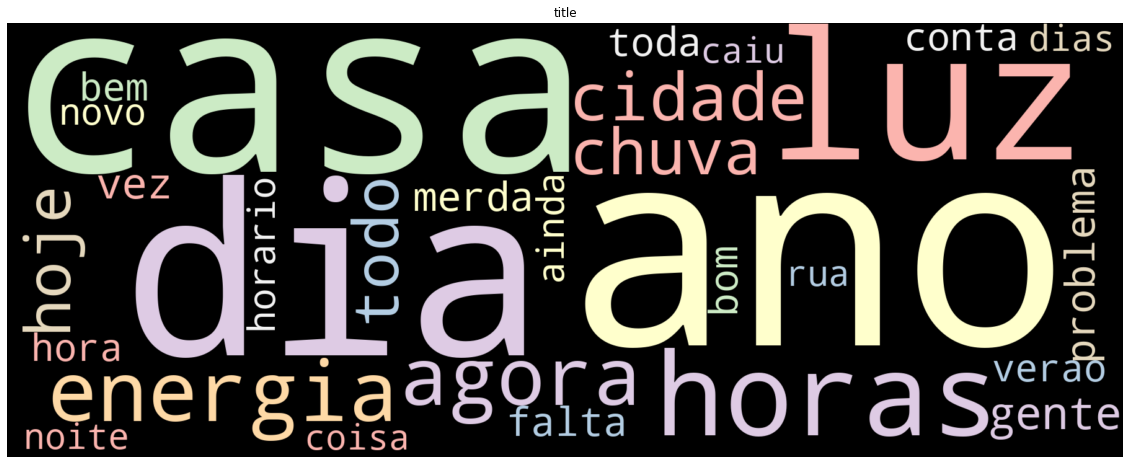

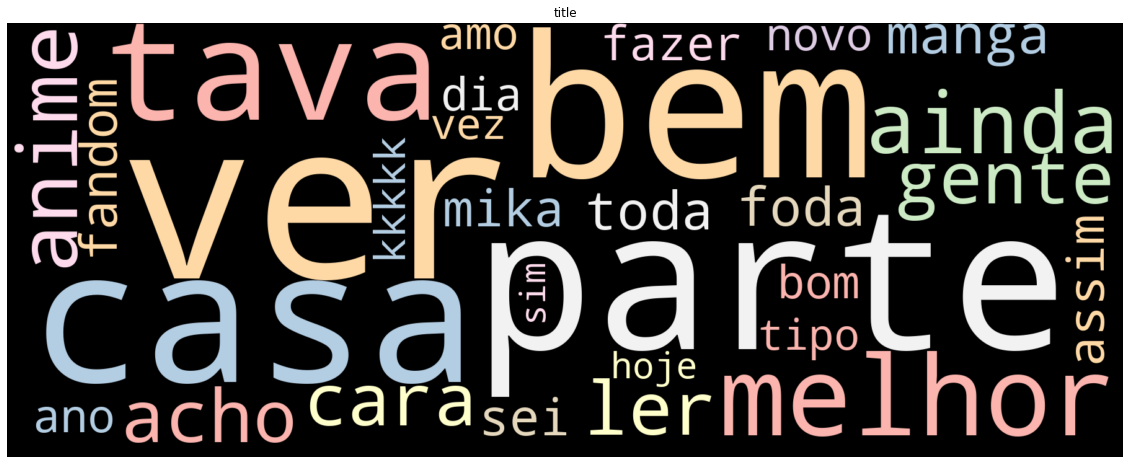

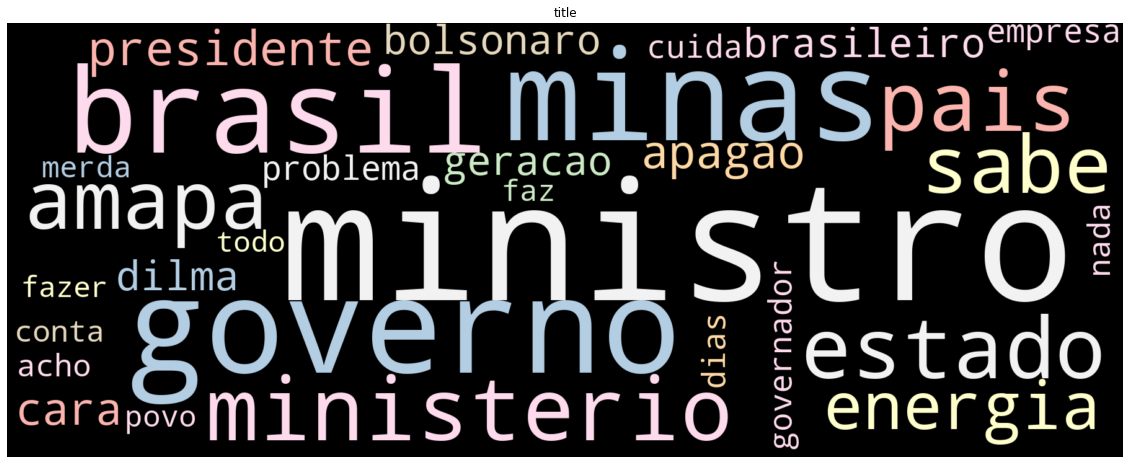

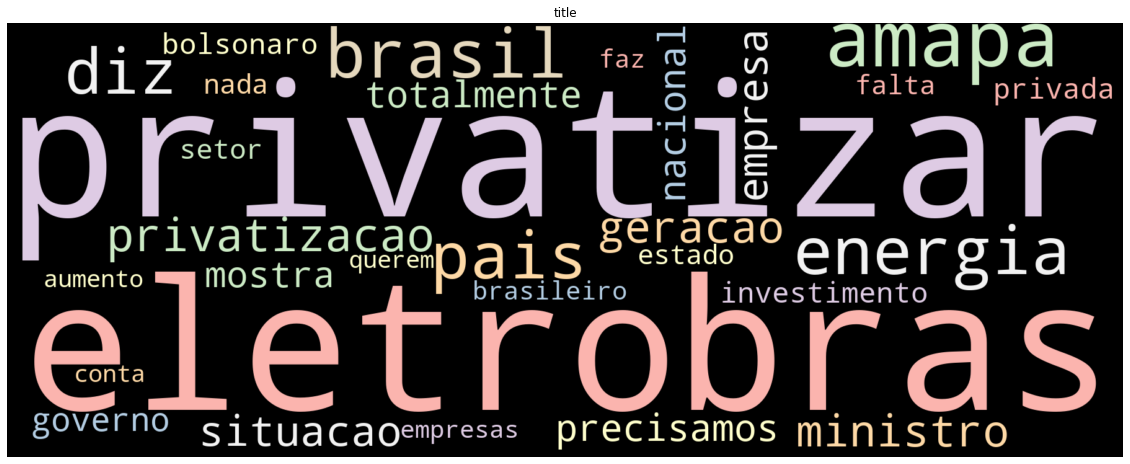

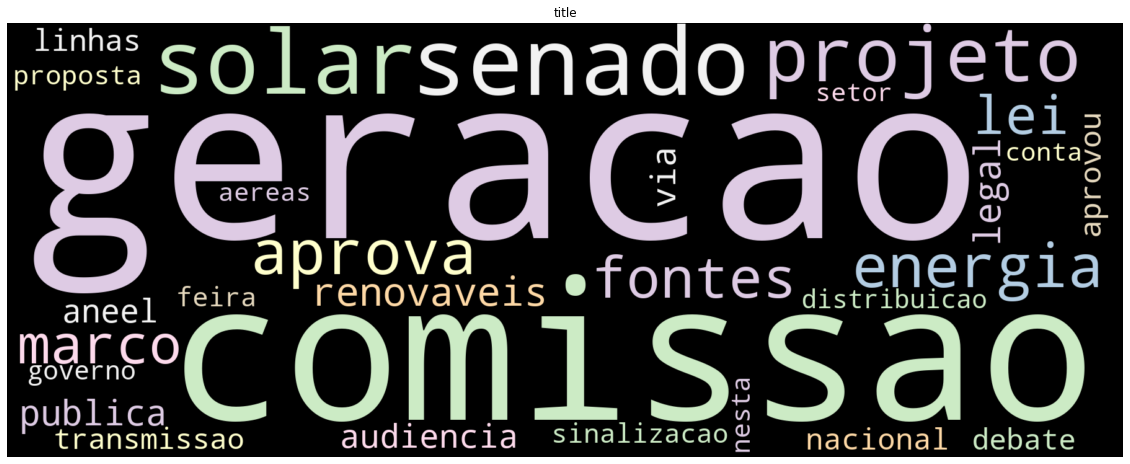

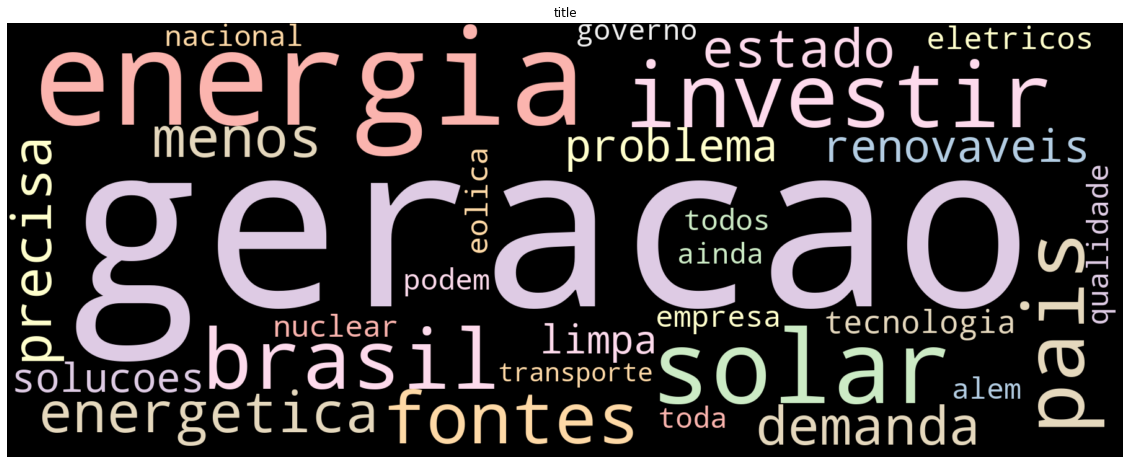

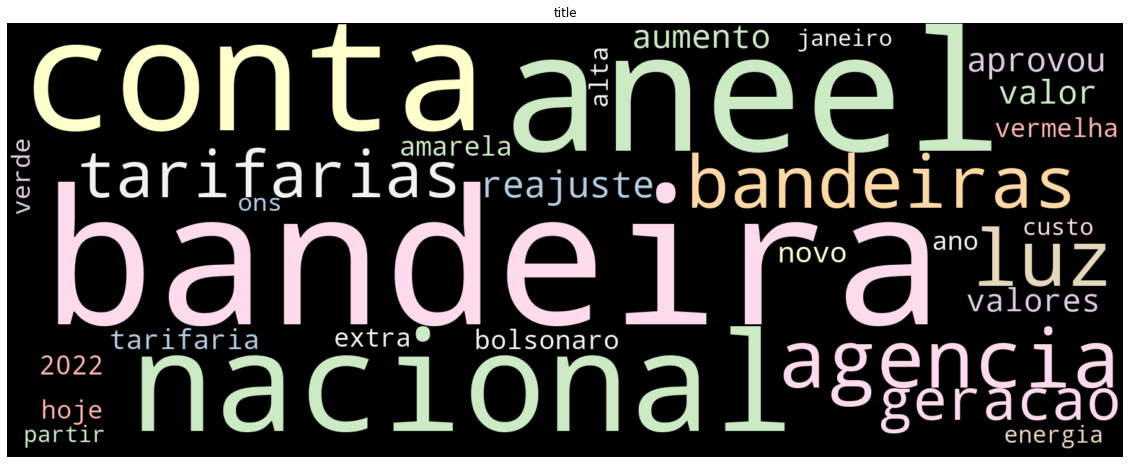

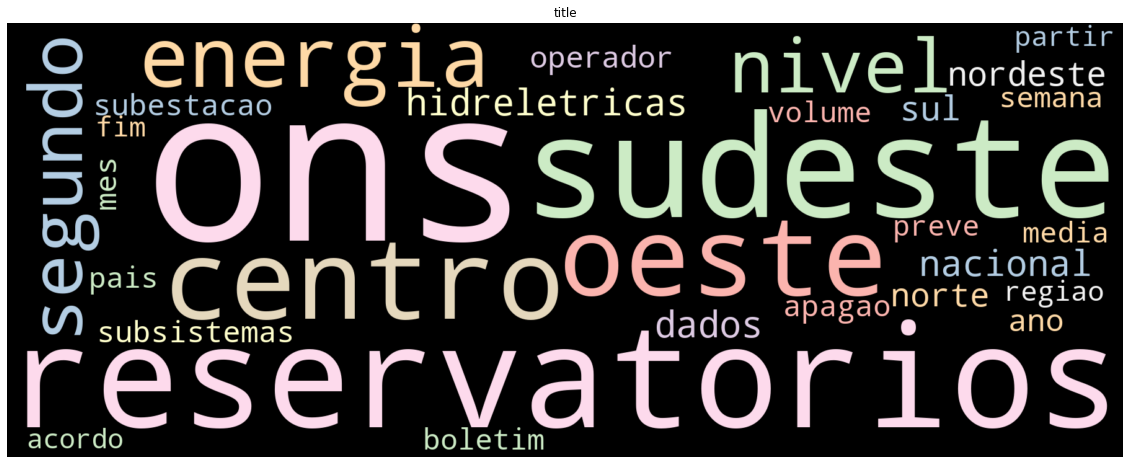

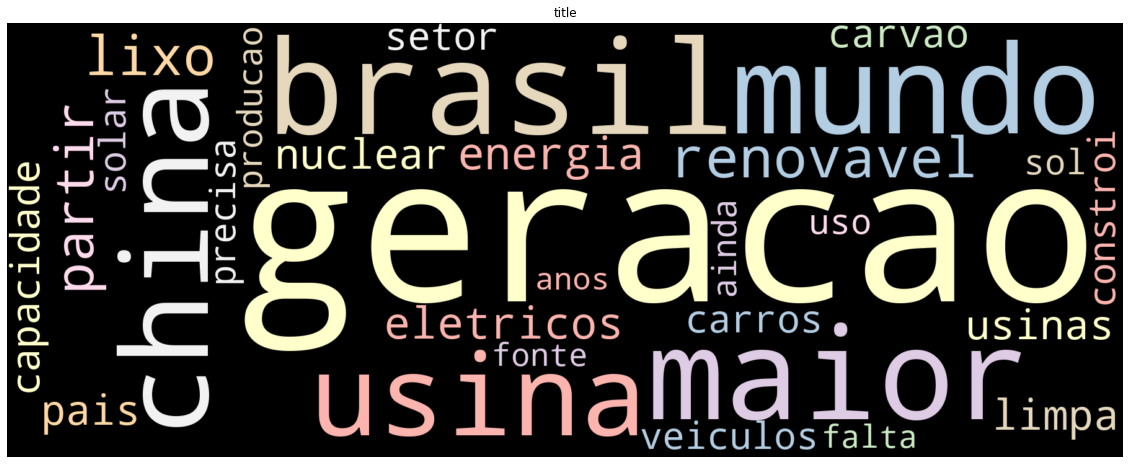

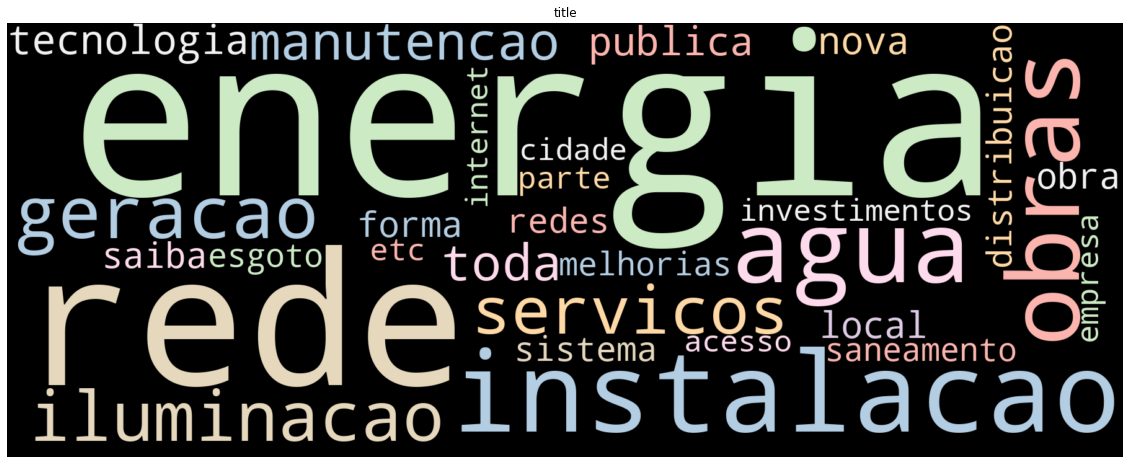

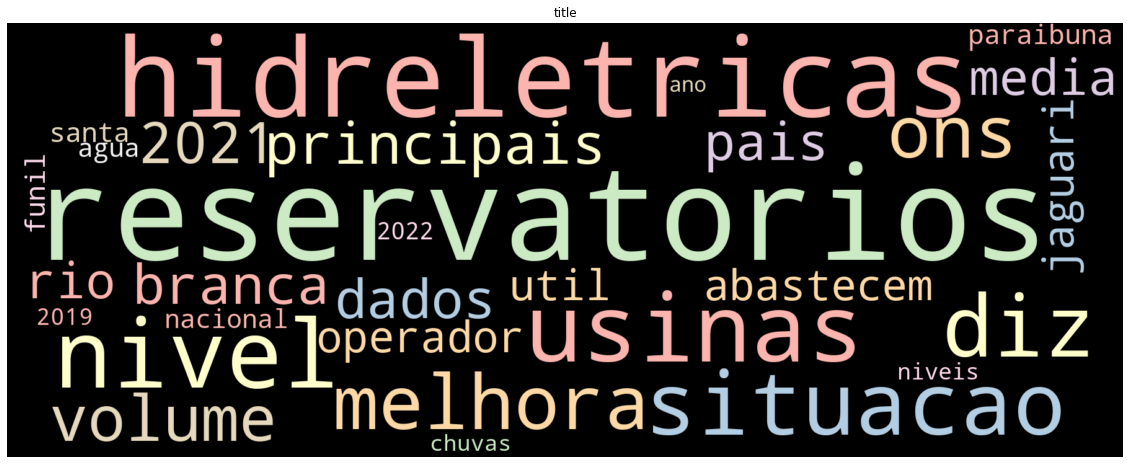

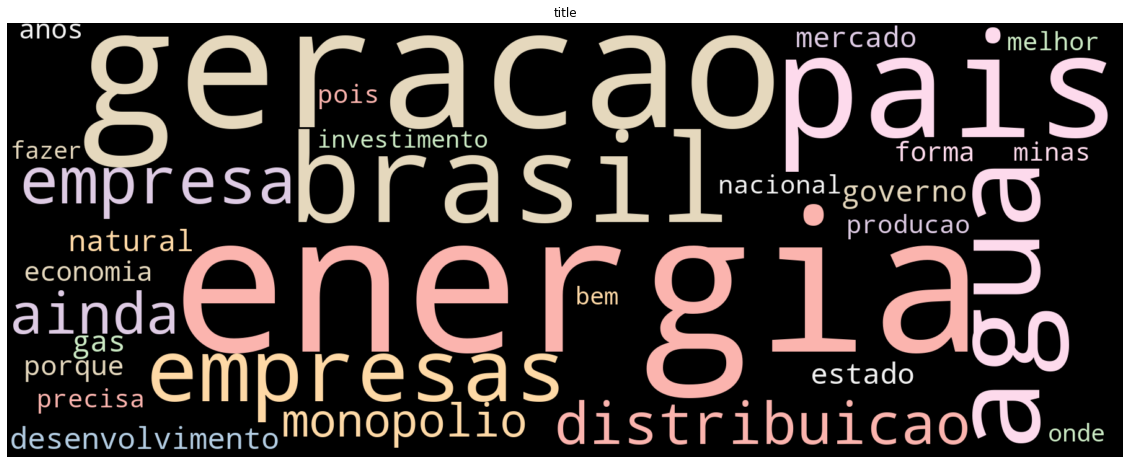

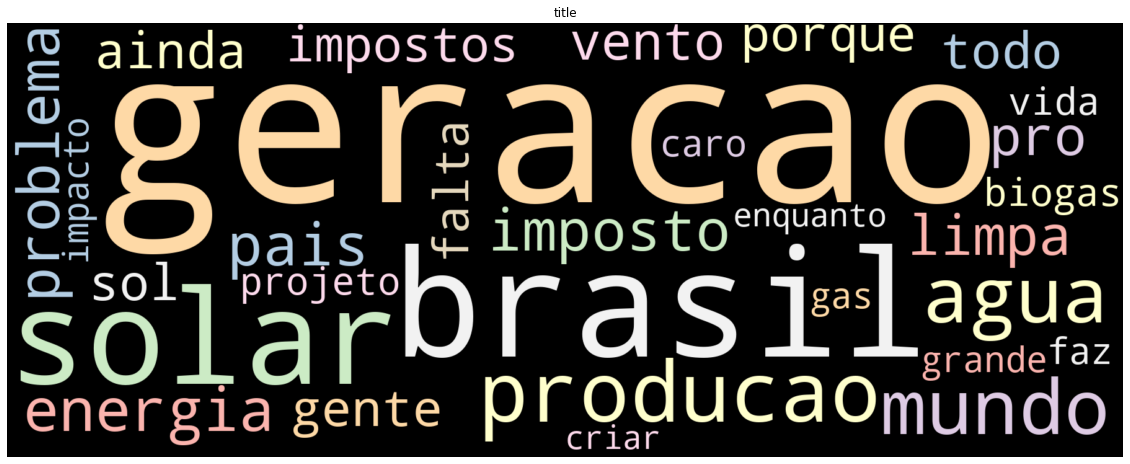

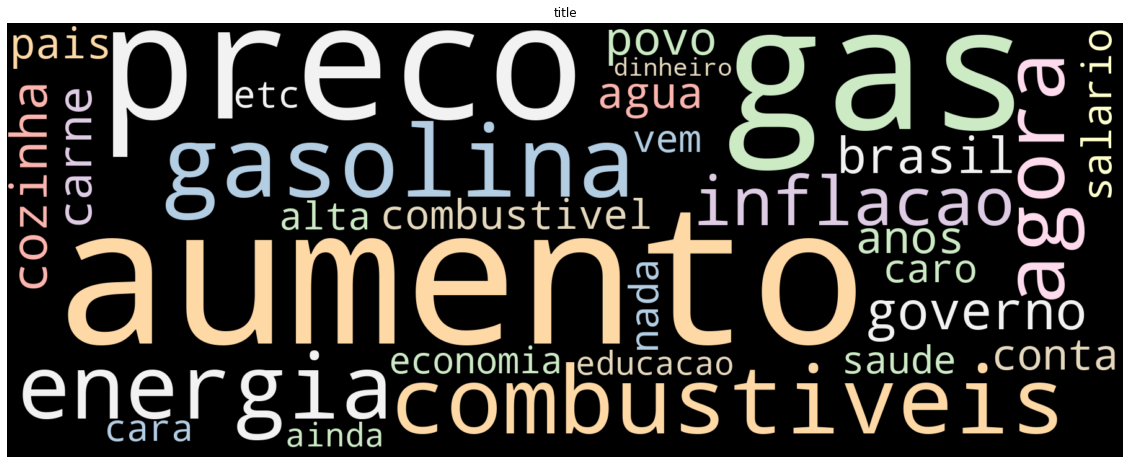

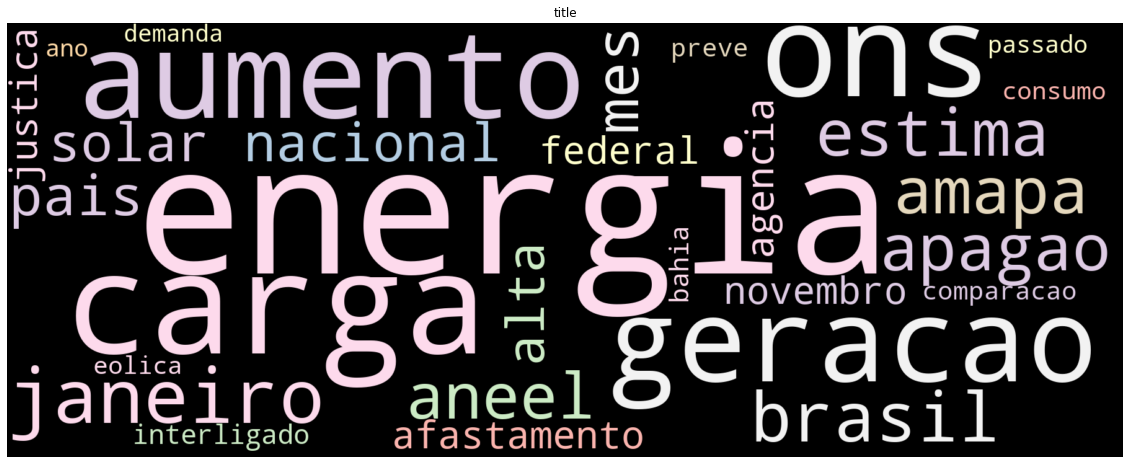

In [28]:
create_wordcloud(top_index)